In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

import torch
import torch.nn as nn
from torch.autograd import Variable
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Epoch Number:  17


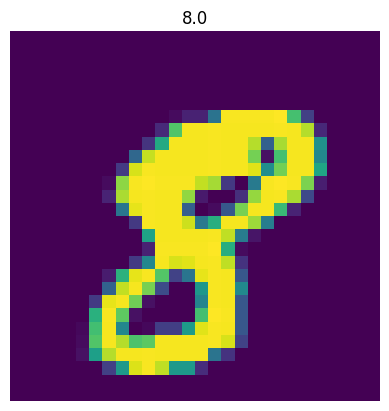

33600
8400


In [4]:
# Import necessary libraries
import pandas as pd
import numpy as np
import torch
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Load the data from CSV file, ensuring that all data is read as float32 for consistency
train = pd.read_csv("/content/drive/MyDrive/Euron/train.csv", dtype=np.float32)

# Split the data into features (pixel values) and labels (digits 0-9)
targets_numpy = train.label.values  # Extract the target labels (digits)
features_numpy = train.loc[:, train.columns != "label"].values / 255  # Normalize pixel values to range [0, 1]

# Split the dataset into training and testing subsets
# 80% of the data is used for training, and 20% is reserved for testing
features_train, features_test, targets_train, targets_test = train_test_split(
    features_numpy,
    targets_numpy,
    test_size=0.2,
    random_state=42  # Ensures reproducibility of the split
)

# Convert the training data (features and labels) to PyTorch tensors
# These tensors are the standard data type used in PyTorch
featuresTrain = torch.from_numpy(features_train)  # Features for training set
targetsTrain = torch.from_numpy(targets_train).type(torch.LongTensor)  # Labels for training set (type: LongTensor)

# Convert the testing data (features and labels) to PyTorch tensors
featuresTest = torch.from_numpy(features_test)  # Features for testing set
targetsTest = torch.from_numpy(targets_test).type(torch.LongTensor)  # Labels for testing set (type: LongTensor)

# Define batch size and the number of iterations for training
batch_size = 100  # Number of samples processed at once
n_iters = 6000  # Total number of iterations
# Calculate the number of epochs (one epoch = processing the entire dataset once)
num_epochs = n_iters / (len(features_train) / batch_size)
num_epochs = int(num_epochs)  # Convert to integer for use in loops
print("Epoch Number: ", num_epochs)  # Print the calculated number of epochs

# Wrap the training data in a TensorDataset object, which pairs features and labels
train = TensorDataset(featuresTrain, targetsTrain)

# Wrap the testing data in a TensorDataset object
test = TensorDataset(featuresTest, targetsTest)

# Create data loaders for both training and testing datasets
# Data loaders make it easier to iterate over batches of data
train_loader = DataLoader(train, batch_size=batch_size, shuffle=False)  # Shuffle is set to False
test_loader = DataLoader(test, batch_size=batch_size, shuffle=False)

# Visualize one of the images in the dataset to verify correctness
# Select the 11th image (index 10), reshape it to 28x28, and display it
plt.imshow(features_numpy[10].reshape(28, 28))  # Reshape the 1D array to a 28x28 image
plt.axis("off")  # Turn off axes for better visualization
plt.title(str(targets_numpy[10]))  # Set the title to the label of the image
plt.savefig('graph.png')  # Save the visualization as 'graph.png'
plt.show()  # Display the image

# Print the number of samples in the training and testing datasets
print(len(train_loader.dataset))  # Number of training samples
print(len(test_loader.dataset))  # Number of testing samples


In [5]:
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim):
        super(LSTMModel, self).__init__()

        # Hidden dimensions
        self.hidden_dim = hidden_dim

        # Number of hidden layers
        self.layer_dim = layer_dim

        # LSTM
        self.lstm = nn.LSTM(input_dim, hidden_dim, layer_dim, batch_first=True) # batch_first=True (batch_dim, seq_dim, feature_dim)

        # Readout layer
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # Initialize hidden state with zeros
        h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).requires_grad_()

        # Initialize cell state
        c0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).requires_grad_()

        # 28 time steps
        # We need to detach as we are doing truncated backpropagation through time (BPTT)
        # If we don't, we'll backprop all the way to the start even after going through another batch
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))

        # Index hidden state of last time step
        # out.size() --> 100, 28, 100
        # out[:, -1, :] --> 100, 100 --> just want last time step hidden states!
        out = self.fc(out[:, -1, :])
        # out.size() --> 100, 10
        return out

input_dim = 28
hidden_dim = 100
layer_dim = 1
output_dim = 10
model = LSTMModel(input_dim, hidden_dim, layer_dim, output_dim)

error = nn.CrossEntropyLoss()

learning_rate = 0.1
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [6]:
# Number of steps to unroll
seq_dim = 28
loss_list = []
iteration_list = []
accuracy_list = []
count = 0
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        # Load images as a torch tensor with gradient accumulation abilities
        images = images.view(-1, seq_dim, input_dim).requires_grad_()

        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()

        # Forward pass to get output/logits
        # outputs.size 100, 10
        outputs = model(images)

        # Calculate Loss: softmax --> cross entropy loss
        loss = error(outputs, labels)

        # Getting gradients
        loss.backward()

        # Updating parameters
        optimizer.step()

        count += 1

        if count % 500 == 0:
            # Calculate Accuracy
            correct = 0
            total = 0
            for images, labels in test_loader:

                images = images.view(-1, seq_dim, input_dim)

                # Forward pass only to get logits/output
                outputs = model(images)

                # Get predictions from the maximum value
                _, predicted = torch.max(outputs.data, 1)

                # Total number of labels
                total += labels.size(0)

                # Total correct predictions
                correct += (predicted == labels).sum()

            accuracy = 100 * correct / total

            loss_list.append(loss.data.item())
            iteration_list.append(count)
            accuracy_list.append(accuracy)

            # Print Loss
            print('Iteration: {}. Loss: {}. Accuracy: {}'.format(count, loss.data.item(), accuracy))

Iteration: 500. Loss: 2.2704079151153564. Accuracy: 18.964284896850586
Iteration: 1000. Loss: 0.9806709289550781. Accuracy: 70.88095092773438
Iteration: 1500. Loss: 0.3712625801563263. Accuracy: 87.42857360839844
Iteration: 2000. Loss: 0.2540120482444763. Accuracy: 92.79762268066406
Iteration: 2500. Loss: 0.16628789901733398. Accuracy: 94.39286041259766
Iteration: 3000. Loss: 0.16219577193260193. Accuracy: 95.67857360839844
Iteration: 3500. Loss: 0.09699591994285583. Accuracy: 95.67857360839844
Iteration: 4000. Loss: 0.01895790547132492. Accuracy: 96.33333587646484
Iteration: 4500. Loss: 0.08164451271295547. Accuracy: 96.63095092773438
Iteration: 5000. Loss: 0.028148088604211807. Accuracy: 97.04762268066406
Iteration: 5500. Loss: 0.13487602770328522. Accuracy: 96.98809814453125


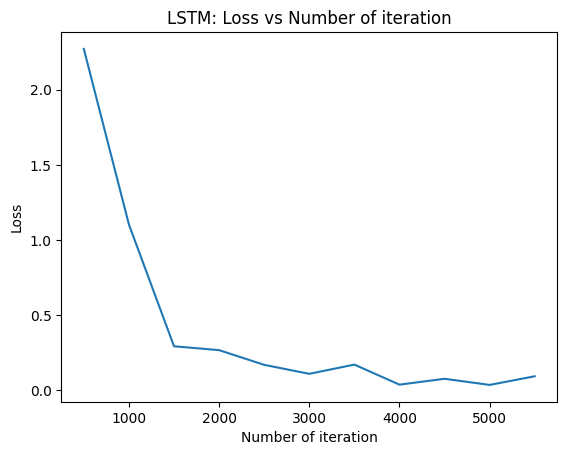

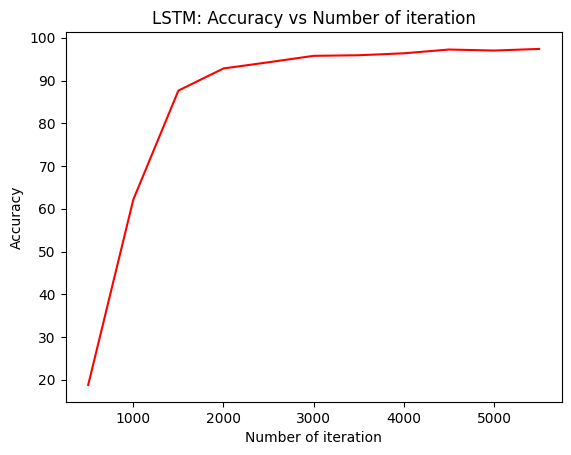

In [ ]:
# visualization loss
plt.plot(iteration_list,loss_list)
plt.xlabel("Number of iteration")
plt.ylabel("Loss")
plt.title("LSTM: Loss vs Number of iteration")
plt.show()

# visualization accuracy
plt.plot(iteration_list,accuracy_list,color = "red")
plt.xlabel("Number of iteration")
plt.ylabel("Accuracy")
plt.title("LSTM: Accuracy vs Number of iteration")
plt.savefig('graph.png')
plt.show()